In [2]:
from GP_recovery import *

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# from NEID_solar_functions import *
from GP_kernels import *

import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp
import jaxopt

jax.config.update("jax_enable_x64", True)



In [47]:
def gaussian_2(x, amp, mu, sig):
    return amp * jnp.exp(-jnp.power(x - mu, 2.) / (2 * jnp.power(sig, 2.))) 

# Example: the Covariance function (kernel) can be used to visualise the differnce in the oscillation parameters

In [48]:
uHz_conv = 1e-6 * 60
amp, mu, sig = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])    
amp *= 6e1 # change amp to 60
nu_max = mu
delta_nu = 135
epsilon = 0
Q = 4e2
N = 11 # 25*135/2=1620
kernel = 0  

for i in range(N):
# for i in [-7, -5, -3, -2, -1, 0, 1, 2, 3, 5, 7]:
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

0.17815398337889624
0.22196452877492187
0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595
0.22196452877492187
0.17815398337889624


In [49]:
Q = 200
kernel2 = 0  
for i in range(N):
# for i in [-7, -5, -3, -2, -1, 0, 1, 2, 3, 5, 7]:
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    kernel2 += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

0.17815398337889624
0.22196452877492187
0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595
0.22196452877492187
0.17815398337889624


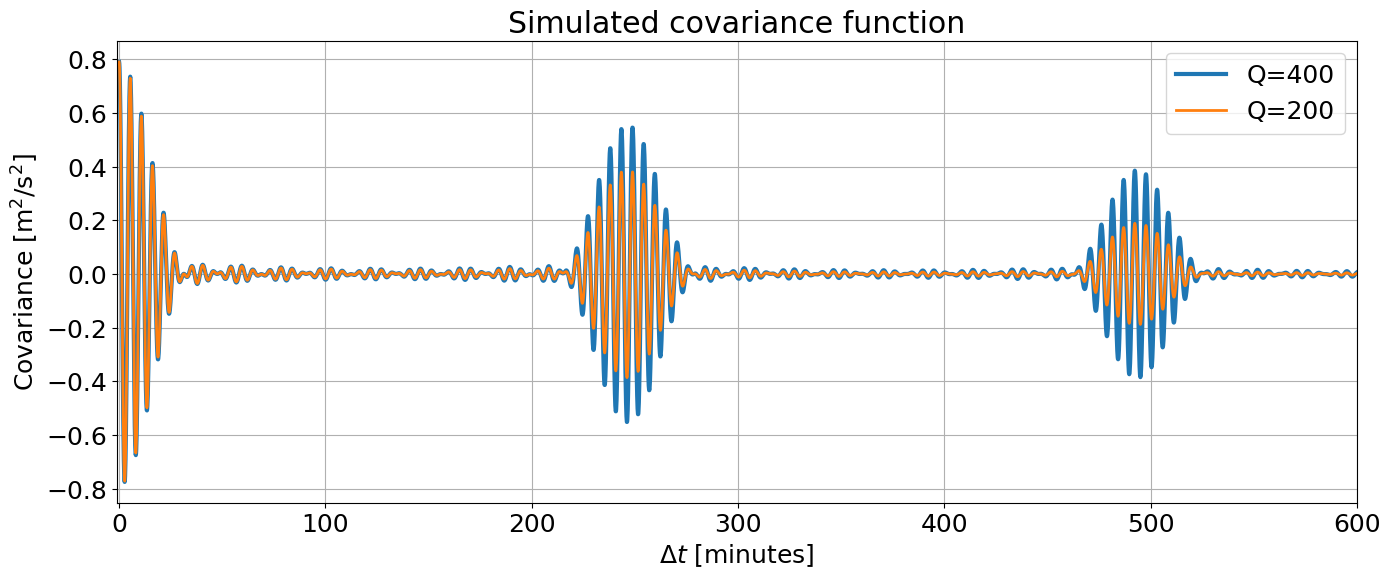

In [50]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))

t = np.linspace(0, 700, 700*10+1)
plt.plot(t, kernel(t, t[:1]), lw=3, alpha=1, label='Q=400')
plt.plot(t, kernel2(t, t[:1]), lw=2, alpha=1, label='Q=200')
plt.title('Simulated covariance function')
plt.xlim([-1,600])
# plt.ylim([-0.7,0.9])
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.grid()
plt.savefig('./Figure/Simulated covariance function.png')
plt.show()

# The following analysis uses the "kernel" defined above

Note that some of the true parameters are

amp(A) = 60

nu_max = 3080.82489

delta_nu = 135

epsilon = 0

Q = 400


In [51]:
Nr = 2
t = np.linspace(0, 700, 700*10+1)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
# y = y[0,:]
t.shape, y.shape

((7001,), (2, 7001))

Text(0.5, 0, '$t$ [minutes]')

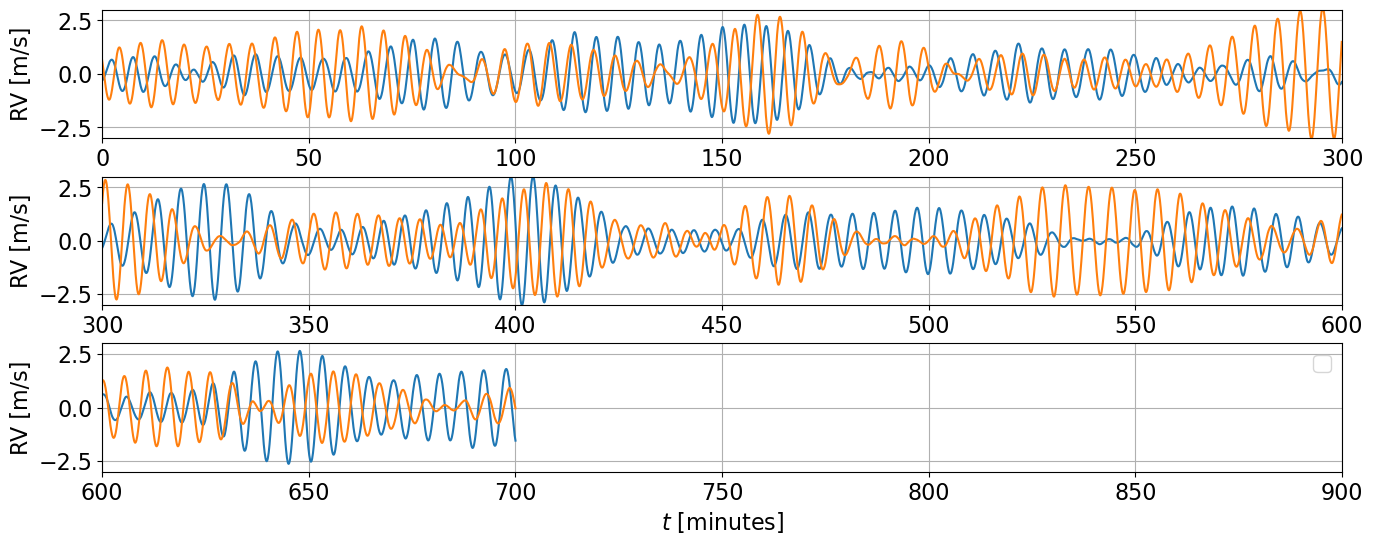

In [52]:
T_env = 300

plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(3, 1, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3)
# axs[0].set_title(str(date)[:10])
for i in range(3):
    idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
    # idx_x = ((x>=i*T_env) & (x<(i+1)*T_env))
    axs[i].plot(t[idx_t], y[:,idx_t].T, '-', alpha=1)
    # axs[i].plot(x[idx_x], pred_mean[idx_x], color='k', alpha=0.8, label='GP$_1$')
    # axs[i].plot(x[idx_x], pred_mean_25[idx_x], color='r', alpha=0.8, label='model GP$_2$')    
    # axs[i].fill_between(x[idx_x], pred_mean[idx_x]+pred_std[idx_x], pred_mean[idx_x]-pred_std[idx_x], color='b', alpha=0.1,
    #                  edgecolor="none")
    # axs[i].fill_between(x[idx_x], pred_mean_25[idx_x]+pred_std_25[idx_x], pred_mean_25[idx_x]-pred_std_25[idx_x], color='b', alpha=0.1,
    #                  edgecolor="none")    
    axs[i].set_ylabel('RV [m/s]')
    axs[i].set_xlim([i*T_env, (i+1)*T_env])
    axs[i].set_ylim([-3, 3])    
    axs[i].grid(True)
axs[-1].legend()
axs[-1].set_xlabel('$t$ [minutes]')
# plt.savefig('GP_model_comparison.png')

In [53]:
y = y[0,:]

## Retrieve some parameters while other parameters are given

In [54]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X, diag=jnp.exp(theta["log_diag"])), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: 4280.971402116432
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-46.12899965, dtype=float64), 'log_diag': DeviceArray(3405.91184078, dtype=float64)}


In [44]:
def solve():
    # w_init = jnp.zeros(len(theta_init))
    # lower_bounds = jnp.ones_like(w_init)* (-1)
    # upper_bounds = jnp.ones_like(w_init) * jnp.inf
    # bounds = (lower_bounds, upper_bounds)

    import jaxopt
    solver = jaxopt.ScipyMinimize(method='BFGS', fun=neg_log_likelihood)#, maxiter=1000)
    soln = solver.run(theta_init, X=t, y=y)
    # soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

    for key, value in soln.params.items():
        print(key[4:], np.exp(value))
    
    model_gp, _ = build_gp(soln.params, t)
    
    fig = plt.figure(figsize=(16, 6))
    plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
    plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
    plt.title('Kernels')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.legend()
    plt.show()

### Retrieve Q

Final negative log likelihood: -33420.47555208625
Q 390.96608584960336
diag 8.691652835516792e-09


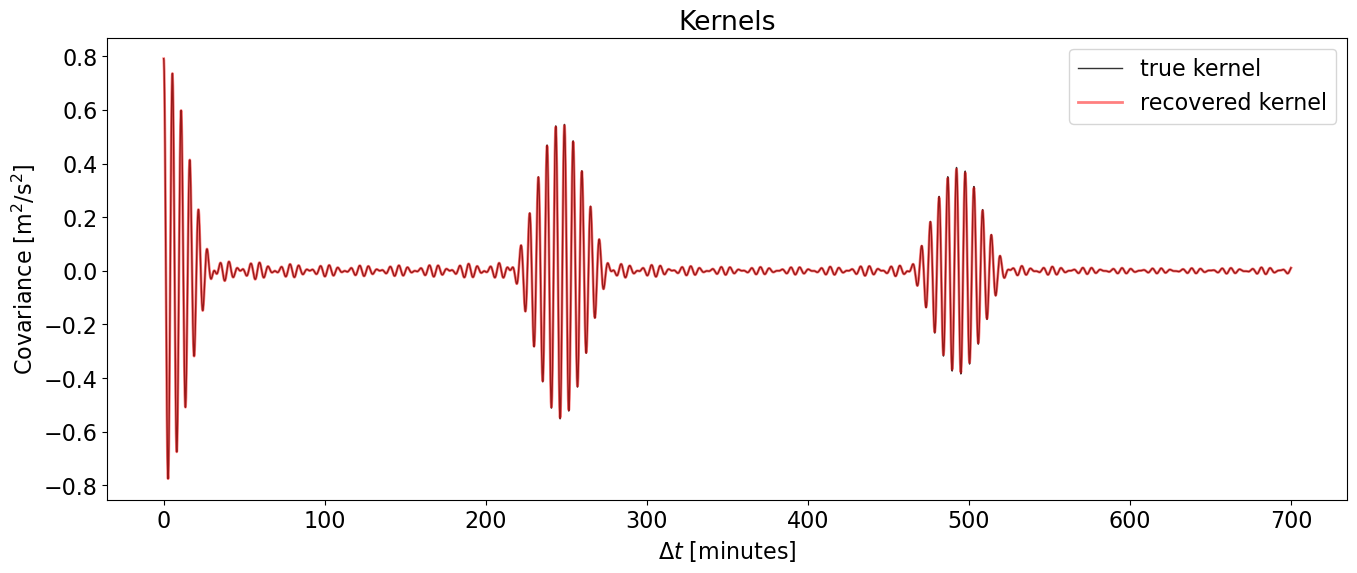

In [17]:
 solve()

### Q, delta_nu

Initial negative log likelihood: 4267.414793053862
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(0.32832529, dtype=float64), 'log_delta_nu': DeviceArray(-562.50210006, dtype=float64), 'log_diag': DeviceArray(3417.76453094, dtype=float64)}
Final negative log likelihood: -32738.728618236186
Q 454.34297907075177
delta_nu 0.02350655321611595
diag 4.05138508763624e-14


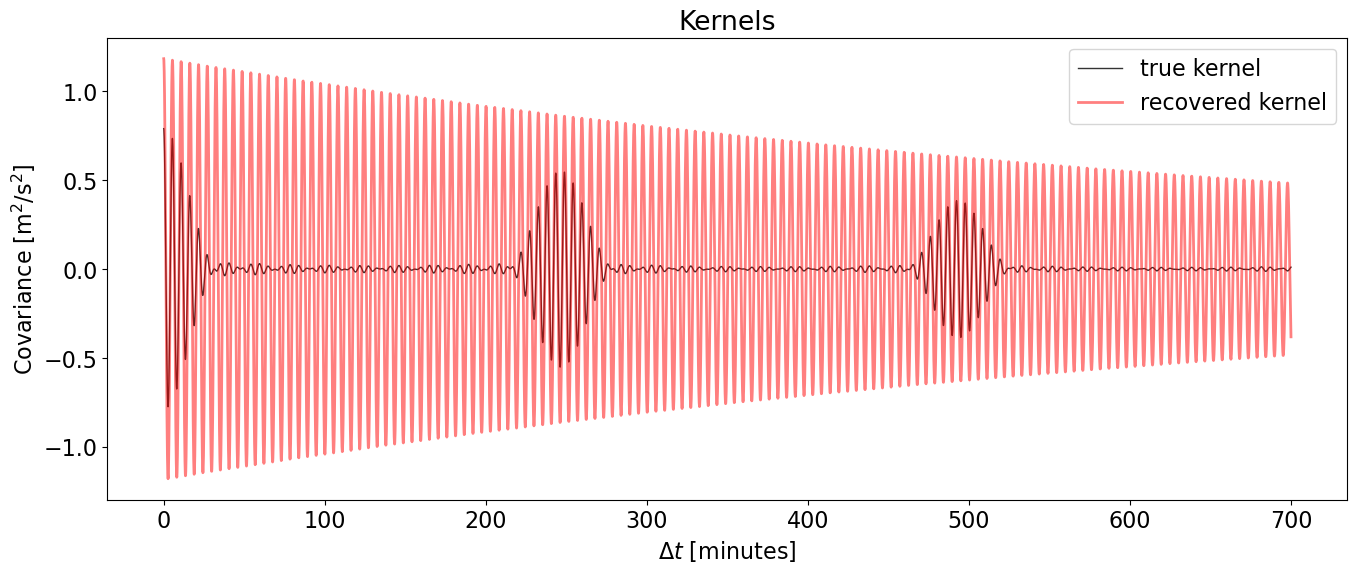

In [45]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X, diag=jnp.exp(theta["log_diag"])), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(500),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(130),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max

Initial negative log likelihood: -32867.32969713353
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-1475.12312045, dtype=float64), 'log_nu_max': DeviceArray(-4457.79178057, dtype=float64)}
Final negative log likelihood: -33373.13753755069
Q 366.1560345343278
nu_max 3014.656049229056


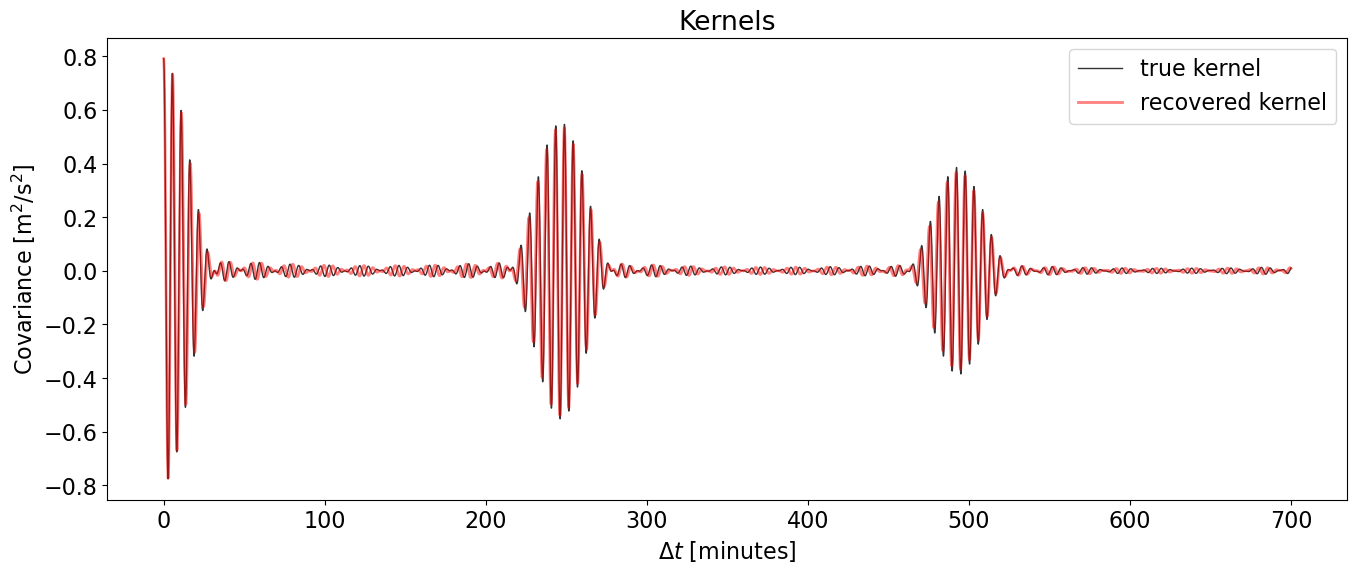

In [19]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A

Initial negative log likelihood: -31906.52757652603
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-7843.92888561, dtype=float64), 'log_Q': DeviceArray(3834.93067195, dtype=float64), 'log_nu_max': DeviceArray(-46914.62584688, dtype=float64)}
Final negative log likelihood: -33373.45028218167
A 0.3588035446582673
Q 437.78791732156407
nu_max 3014.620734236335


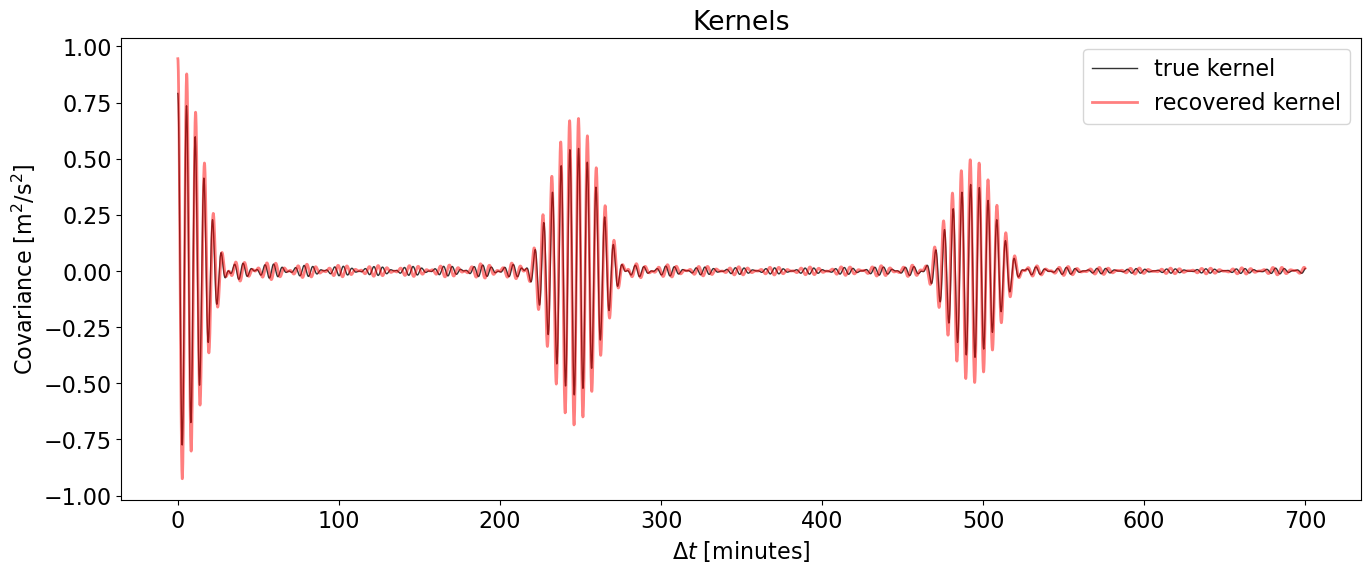

In [20]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu

Initial negative log likelihood: -31863.94016754745
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-8052.99645626, dtype=float64), 'log_Q': DeviceArray(3931.03718317, dtype=float64), 'log_delta_nu': DeviceArray(1819.97253239, dtype=float64), 'log_nu_max': DeviceArray(-38316.4049814, dtype=float64)}
Final negative log likelihood: -33376.20837261249
A 0.36402627520617037
Q 443.63513180047136
delta_nu 138.04470995850895
nu_max 3012.094363928166


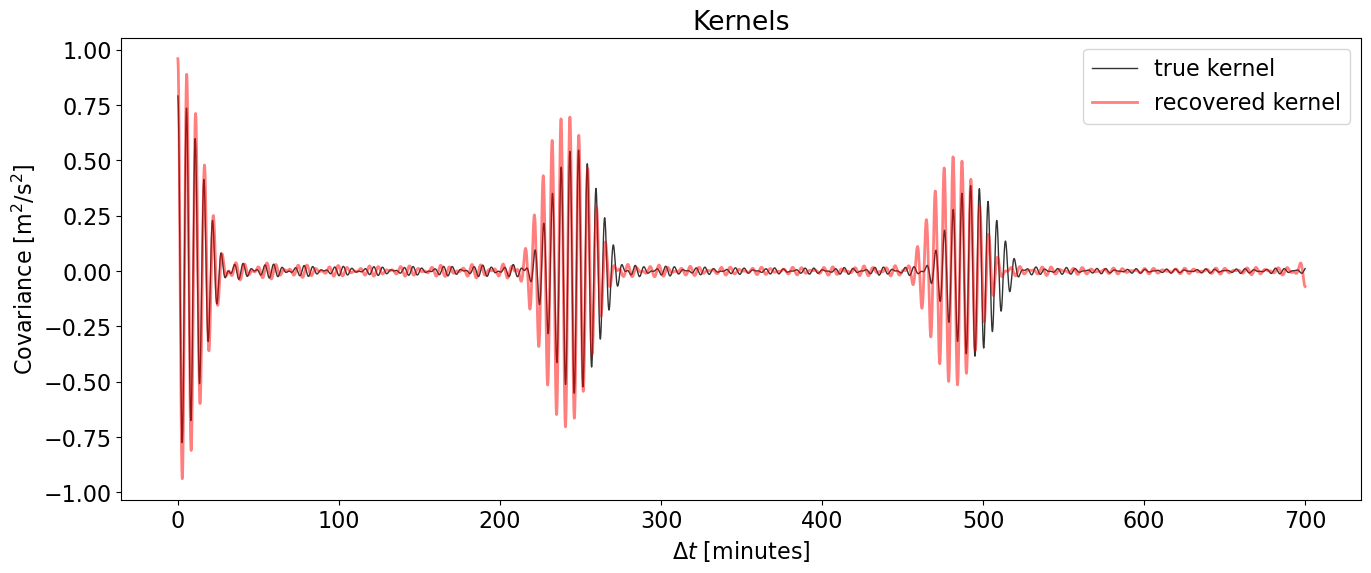

In [22]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W

Initial negative log likelihood: -31810.412585257964
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-8227.98300406, dtype=float64), 'log_Q': DeviceArray(4016.32589463, dtype=float64), 'log_W': DeviceArray(-3082.65027768, dtype=float64), 'log_delta_nu': DeviceArray(1925.78488012, dtype=float64), 'log_nu_max': DeviceArray(-38934.25630702, dtype=float64)}
Final negative log likelihood: -33354.967082011906
A 0.3823662081651924
Q 391.9145471857614
W 288.6114735745519
delta_nu 170.76471612900863
nu_max 3000.499927778423


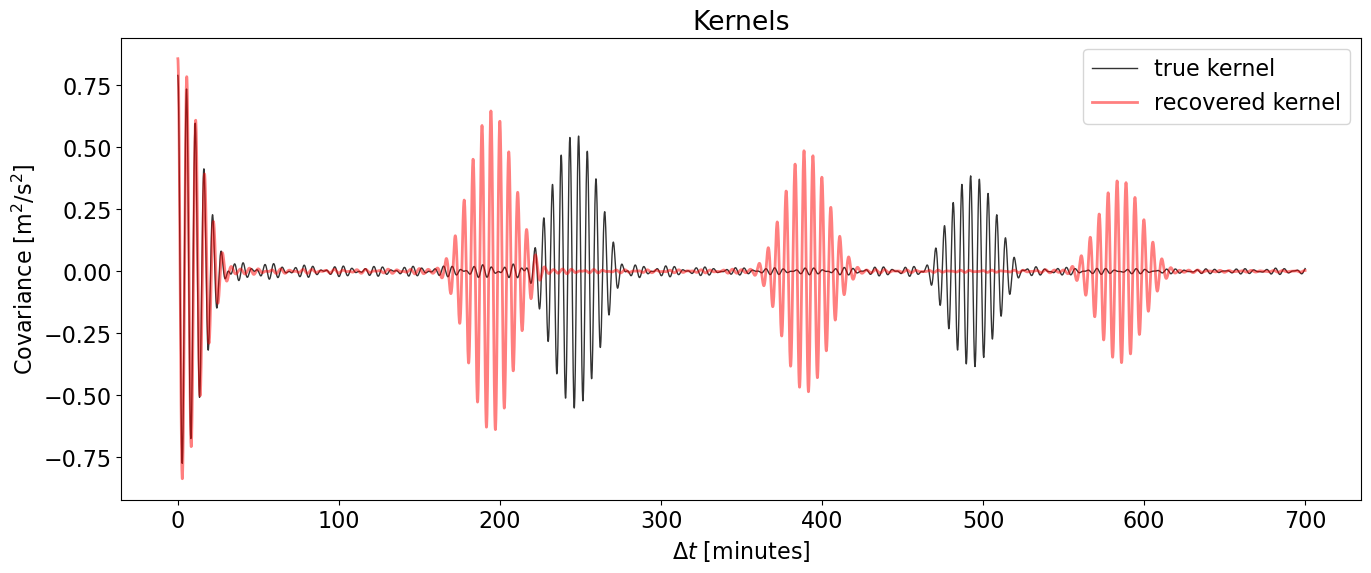

In [23]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W, epsilon

Initial negative log likelihood: -31810.412585257964
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-9.22531263, dtype=float64), 'log_A': DeviceArray(-8227.98300406, dtype=float64), 'log_Q': DeviceArray(4016.32589463, dtype=float64), 'log_W': DeviceArray(-3082.65027768, dtype=float64), 'log_delta_nu': DeviceArray(1925.78488012, dtype=float64), 'log_nu_max': DeviceArray(-38934.25630702, dtype=float64)}
Final negative log likelihood: -33375.32050174264
lon 1.3182593044787097e-41
A 0.4111226053012245
Q 384.68058264836264
W 226.3048372321795
delta_nu 172.85557688596273
nu_max 3089.878099382742


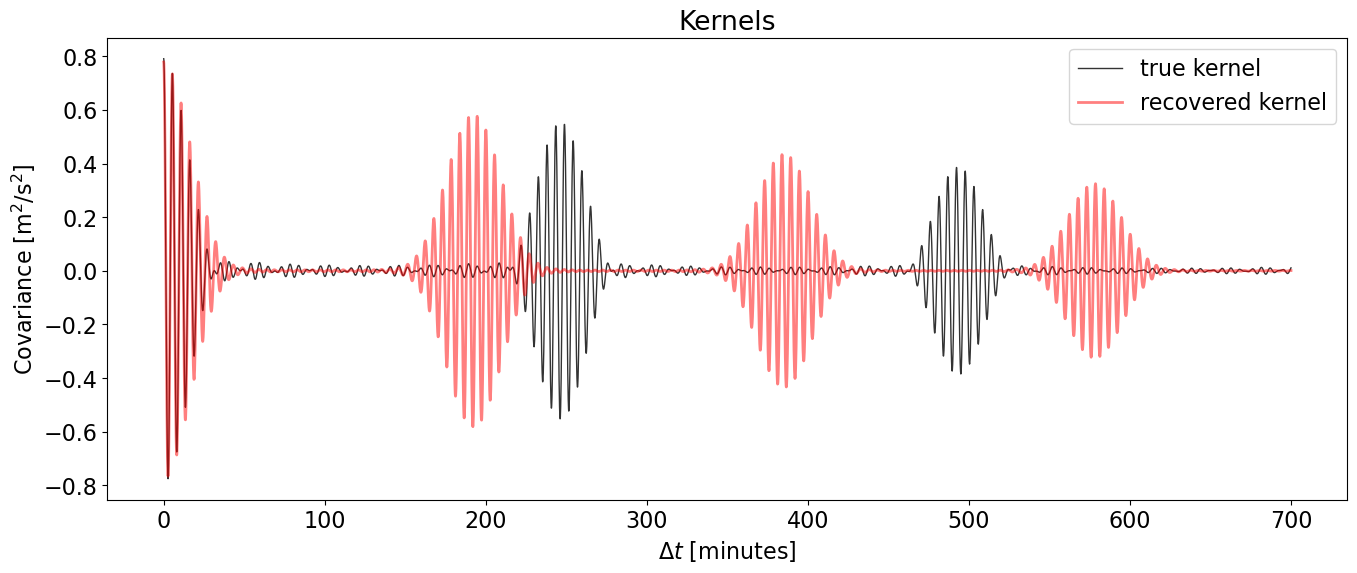

In [24]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### +diag

Initial negative log likelihood: 4384.686144072457
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-6.30897011, dtype=float64), 'log_A': DeviceArray(-273.00668331, dtype=float64), 'log_Q': DeviceArray(49.86993777, dtype=float64), 'log_W': DeviceArray(-143.95501778, dtype=float64), 'log_delta_nu': DeviceArray(-318.22831121, dtype=float64), 'log_diag': DeviceArray(3392.88829377, dtype=float64), 'log_nu_max': DeviceArray(-20388.14003482, dtype=float64)}
Final negative log likelihood: -32751.382044687154
lon 1.0045266291274402
A 0.9679772006014326
Q 350.2353354300385
W 0.020415161825868965
delta_nu 101.02017194970693
diag 1.4138069690049915e-16
nu_max 3100.8207010755777


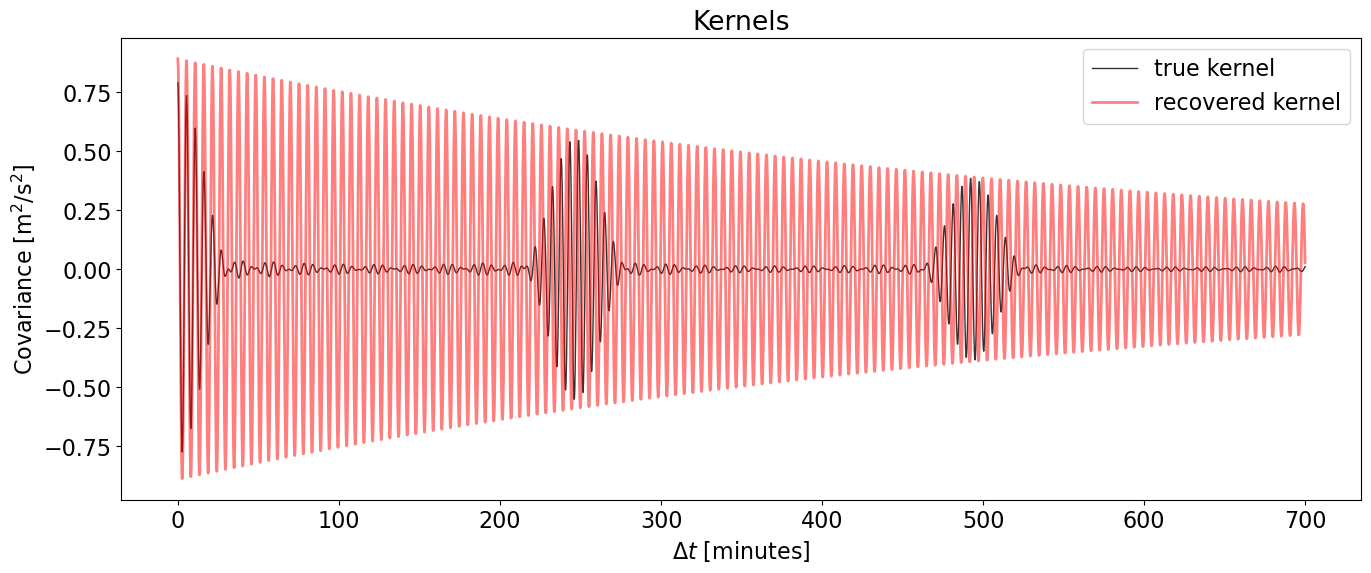

In [25]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"])), kernel           

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### individual

Initial negative log likelihood: 18707.84244191392
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-107812.51336013, dtype=float64), 'log_Q': DeviceArray(53803.39124362, dtype=float64), 'log_nu1': DeviceArray(-542649.48237802, dtype=float64)}
Final negative log likelihood: -32733.815485644955
A1 0.9443045752039391
Q 355.46682331038795
nu1 3100.8214985895074


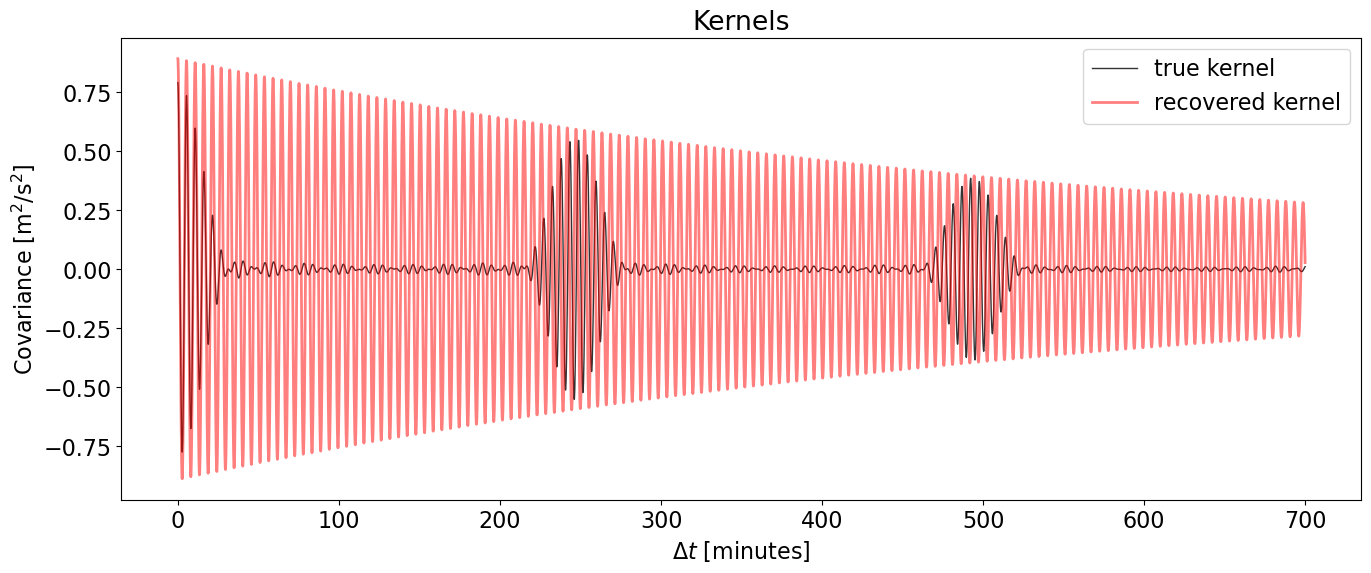

In [26]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu1 = jnp.exp(theta["log_nu1"])
    
    # nu_max = jnp.exp(theta["log_nu_max"])
    A1 = jnp.exp(theta["log_A1"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(1):
        omega = 2*np.pi*nu1*uHz_conv
        sigma = A1
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A1": np.log(0.5*amp),
    "log_nu1": np.log(3000),
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Individual 2

Initial negative log likelihood: -27080.50018992122
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-10867.82578393, dtype=float64), 'log_A2': DeviceArray(-9164.39527783, dtype=float64), 'log_Q': DeviceArray(10007.64974979, dtype=float64), 'log_nu1': DeviceArray(-16697.30843299, dtype=float64), 'log_nu2': DeviceArray(-36397.75912075, dtype=float64)}
Final negative log likelihood: -33042.55598129971
A1 0.7437624618897709
A2 0.41093821591293983
Q 316.7749174661057
nu1 3029.689332448572
nu2 3292.322891052186


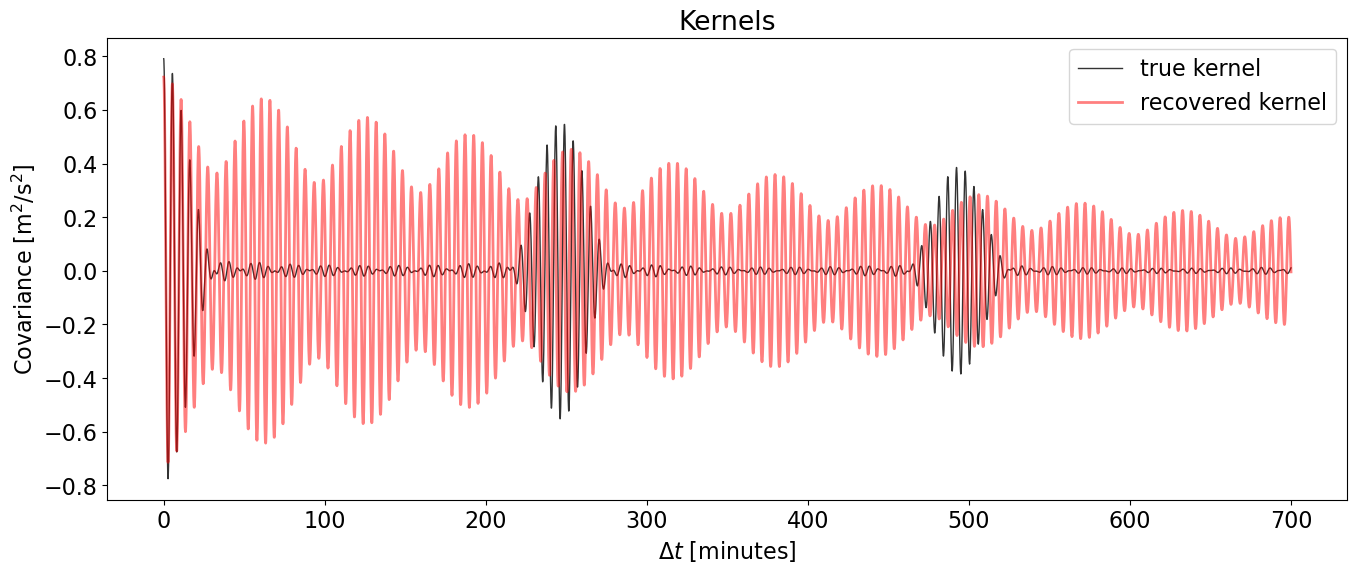

In [27]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu1 = jnp.exp(theta["log_nu1"])
    nu2 = jnp.exp(theta["log_nu2"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    kernel += tinygp.kernels.quasisep.SHO(2*np.pi*nu1*uHz_conv, Q, A1)
    kernel += tinygp.kernels.quasisep.SHO(2*np.pi*nu2*uHz_conv, Q, A2)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(400),
    "log_A1": np.log(1.1*amp),
    "log_nu1": np.log(3000),
    "log_A2": np.log(0.9*amp),
    "log_nu2": np.log(3200),    
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### 7 modes

Initial negative log likelihood: -925.8977595391348
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(28.51807567, dtype=float64), 'log_A2': DeviceArray(24.12121109, dtype=float64), 'log_A3': DeviceArray(28.93010757, dtype=float64), 'log_A4': DeviceArray(21.03470934, dtype=float64), 'log_A5': DeviceArray(28.46183055, dtype=float64), 'log_A6': DeviceArray(12.24002051, dtype=float64), 'log_A7': DeviceArray(-83.8546067, dtype=float64), 'log_Q': DeviceArray(-25.41103788, dtype=float64), 'log_delta_nu': DeviceArray(-366.58675619, dtype=float64), 'log_nu_max': DeviceArray(-9582.41326018, dtype=float64)}
Final negative log likelihood: -1077.76498265781
A1 0.3678794411714424
A2 0.3678794411714424
A3 0.5338991871585221
A4 0.46842607955602333
A5 0.3678794411714424
A6 0.3678794411714424
A7 0.3678794411714424
Q 767.1990503437163
delta_nu 133.51240869596737
nu_max 3080.714578356499


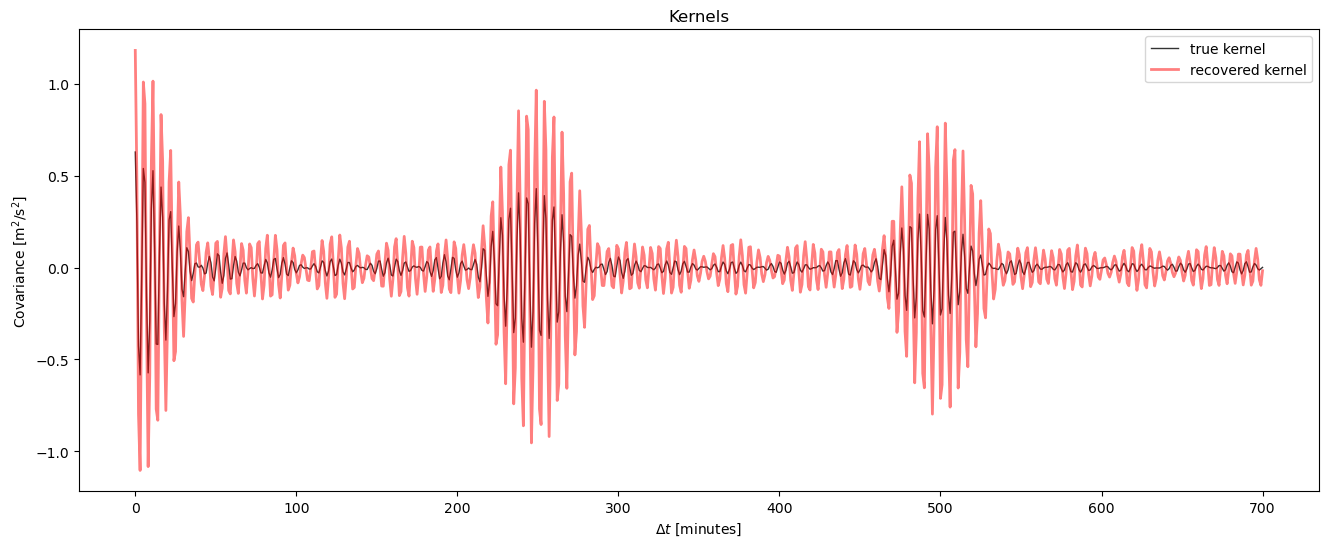

In [42]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(300),
    "log_A1": np.log(0.8*amp),
    "log_A2": np.log(0.9*amp),
    "log_A3": np.log(1*amp),
    "log_A4": np.log(1.1*amp),
    "log_A5": np.log(1.2*amp),
    "log_A6": np.log(1.15*amp),
    "log_A7": np.log(1.05*amp),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [41]:
for i in range(N):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    # kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595


### 9 modes

Initial negative log likelihood: -2034.835850891038
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(5.5751085, dtype=float64), 'log_A2': DeviceArray(-2.74103556, dtype=float64), 'log_A3': DeviceArray(-61.60091726, dtype=float64), 'log_A4': DeviceArray(-7.7241625, dtype=float64), 'log_A5': DeviceArray(-80.10570401, dtype=float64), 'log_A6': DeviceArray(4.42742802, dtype=float64), 'log_A7': DeviceArray(17.09080498, dtype=float64), 'log_A8': DeviceArray(23.84465993, dtype=float64), 'log_A9': DeviceArray(32.75325157, dtype=float64)}
Final negative log likelihood: -2176.267858760456
A1 0.27448049181190265
A2 0.32101400898620375
A3 0.277661448191899
A4 0.3306990074714089
A5 0.3646608011679721
A6 0.2232553498217135
A7 0.2480038927278273
A8 0.018557799230346464
A9 2.6203635907672065e-07


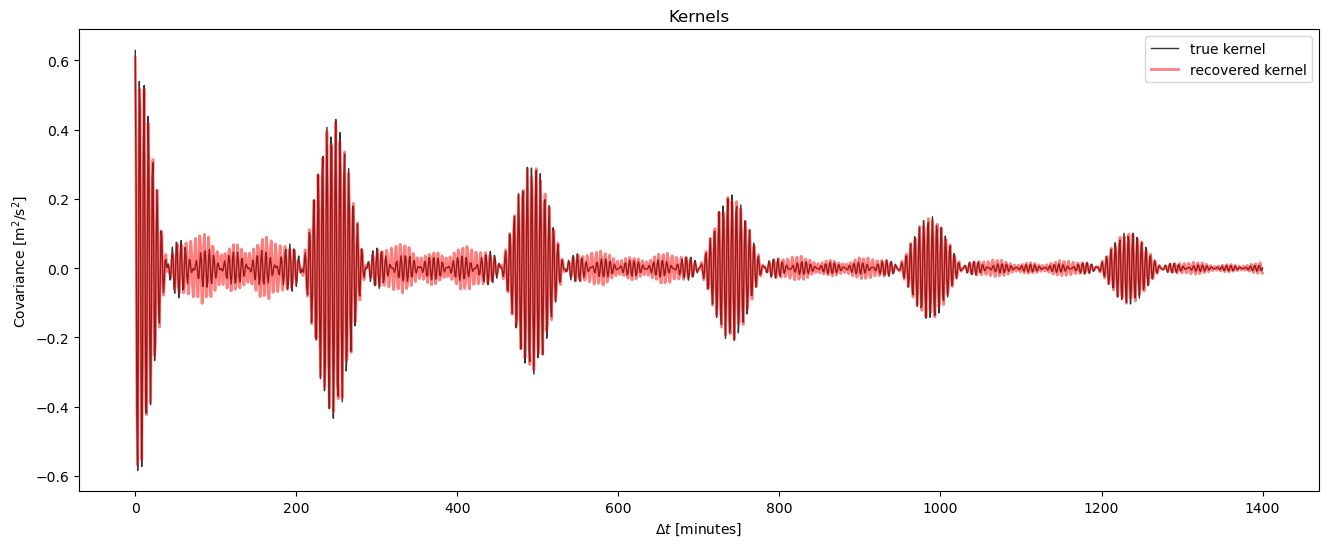

In [61]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = 400
    nu_max = 3080
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = 135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    # "log_Q": np.log(400),
    "log_A1": np.log(0.26),
    "log_A2": np.log(0.30),
    "log_A3": np.log(0.32),
    "log_A4": np.log(0.01),
    "log_A5": np.log(0.32),
    "log_A6": np.log(0.30),
    "log_A7": np.log(0.26),
    "log_A8": np.log(0.26),
    "log_A9": np.log(0.26),
    # "log_nu_max": np.log(3080),
    # "log_delta_nu": np.log(135)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [51]:
for i in range(N):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    # kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595


### fix delta_nu

Initial negative log likelihood: -12827.772394644078
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-326.85073163, dtype=float64), 'log_A2': DeviceArray(-373.31938266, dtype=float64), 'log_A3': DeviceArray(-393.53858695, dtype=float64), 'log_A4': DeviceArray(-430.56435417, dtype=float64), 'log_A5': DeviceArray(-492.02513747, dtype=float64), 'log_A6': DeviceArray(-499.8308797, dtype=float64), 'log_A7': DeviceArray(-537.9574899, dtype=float64), 'log_A8': DeviceArray(-300.33139107, dtype=float64), 'log_A9': DeviceArray(-563.9406404, dtype=float64), 'log_Q': DeviceArray(1924.16651788, dtype=float64), 'log_nu_max': DeviceArray(-24927.63870231, dtype=float64)}
Final negative log likelihood: -13529.786095216241
A1 0.21634949365091627
A2 0.3806770571621002
A3 0.2123946774597854
A4 0.4894492849151209
A5 0.3153059896695263
A6 0.4539908543825858
A7 0.2346550385763801
A8 1.616987853345415e-06
A9 7.798347996767214e-07
Q 532.6525438993316
nu_max 3078.617553179564

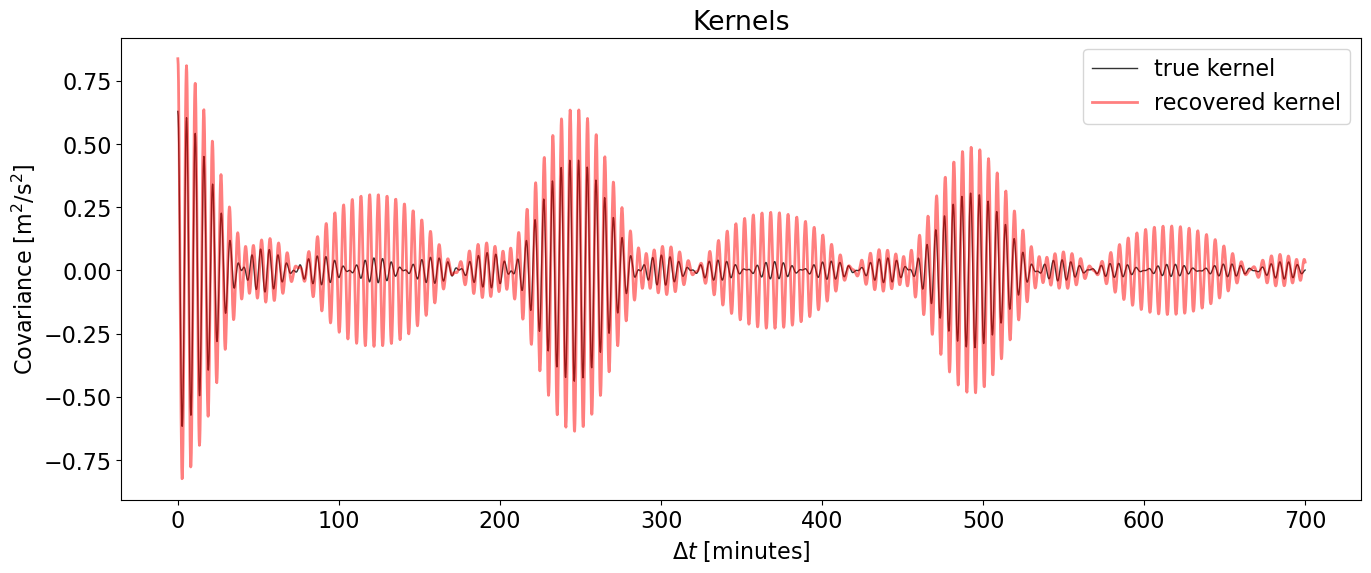

In [93]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = 135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(300),
    "log_A1": np.log(0.5*amp),
    "log_A2": np.log(0.5*amp),
    "log_A3": np.log(0.5*amp),
    "log_A4": np.log(0.5*amp),
    "log_A5": np.log(0.5*amp),
    "log_A6": np.log(0.5*amp),
    "log_A7": np.log(0.5*amp),
    "log_A8": np.log(0.5*amp),
    "log_A9": np.log(0.5*amp),
    "log_nu_max": np.log(3000),
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Fix Q

Initial negative log likelihood: -32269.596266212364
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-848.1816859, dtype=float64), 'log_A2': DeviceArray(-912.50761245, dtype=float64), 'log_A3': DeviceArray(-967.3847941, dtype=float64), 'log_A4': DeviceArray(-1055.12092373, dtype=float64), 'log_A5': DeviceArray(-1104.88004134, dtype=float64), 'log_A6': DeviceArray(-1173.30502737, dtype=float64), 'log_A7': DeviceArray(-1254.50747802, dtype=float64), 'log_A8': DeviceArray(-786.04627545, dtype=float64), 'log_A9': DeviceArray(-1327.99556124, dtype=float64)}
Final negative log likelihood: -34254.68770088494
A1 0.22278758626232764
A2 0.3349444603468135
A3 0.23995563158365696
A4 0.4547758834202915
A5 0.30170349083145687
A6 0.2627396838617425
A7 0.22792053257783504
A8 3.7203099705751224e-06
A9 0.034075470640881136


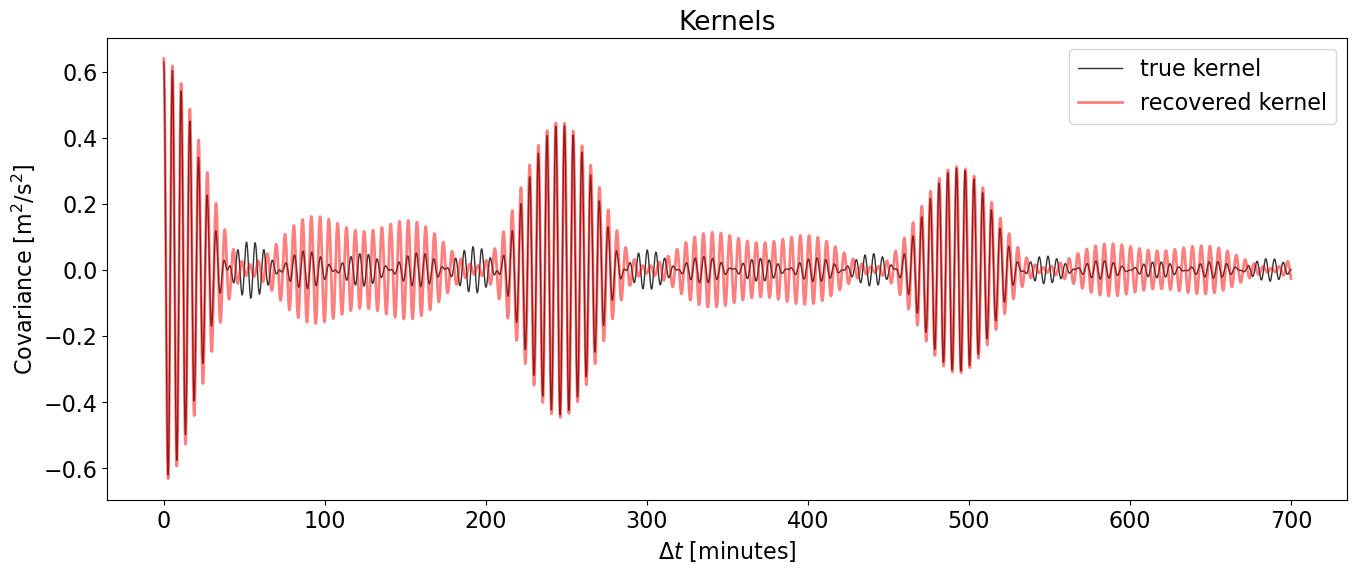

In [140]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = 400
    nu_max = 3080
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = 135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    # return GaussianProcess(kernel, X, diag=jnp.exp(theta["log_diag"])), kernel
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    # "log_Q": np.log(300),
    "log_A1": np.log(0.5*amp),
    "log_A2": np.log(0.5*amp),
    "log_A3": np.log(0.5*amp),
    "log_A4": np.log(0.5*amp),
    "log_A5": np.log(0.5*amp),
    "log_A6": np.log(0.5*amp),
    "log_A7": np.log(0.5*amp),
    "log_A8": np.log(0.5*amp),
    "log_A9": np.log(0.5*amp),
    # "log_nu_max": np.log(3000),
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [127]:
for i in range(N):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    # kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)


0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595
